In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm

from UseEnvDT import UseEnvDigitalTwin as ue

In [2]:
import seaborn as sns


In [3]:
env_data_dr = "./data/"
ds = pd.read_csv(env_data_dr+"WeatherTide_digitaltwin_1h.csv")

# Missing values

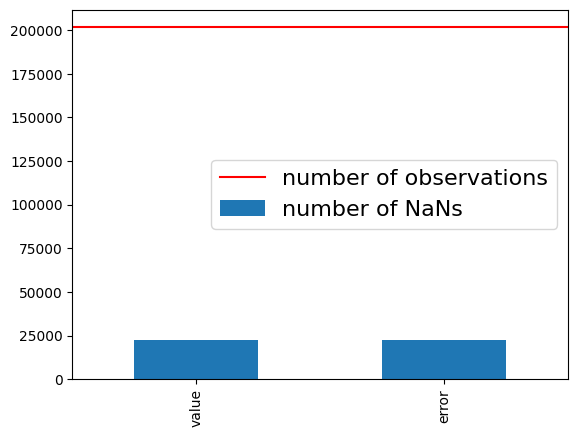

In [4]:
missing = ds.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
f, ax = plt.subplots()


missing.plot.bar(label="number of NaNs");
plt.axhline(y=ds.shape[0], color="red", label="number of observations")
plt.legend(fontsize=16);

## Time Series

In [5]:
ds["date"] = pd.to_datetime(ds["date"])

tide - time series

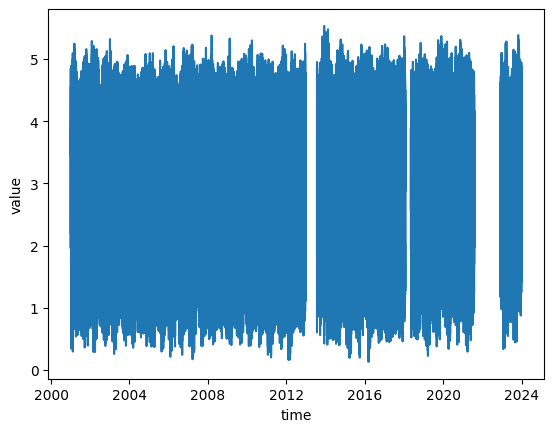

In [6]:
ue(ds).time_series("value")

precipitation - time series

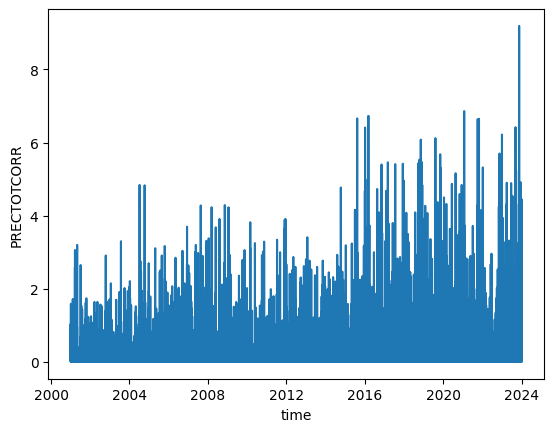

In [7]:
ue(ds).time_series("PRECTOTCORR")

wind speed - time series

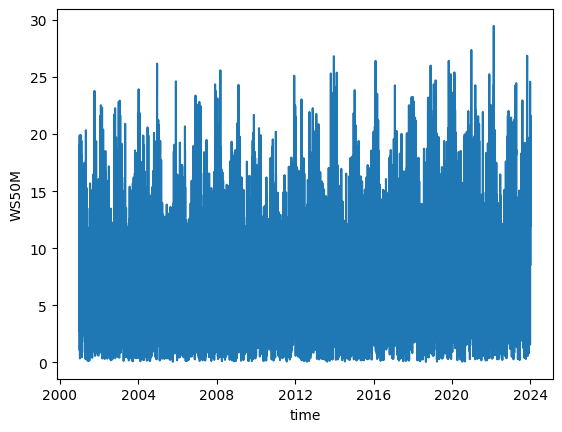

In [8]:
ue(ds).time_series("WS50M")

brightness - time series

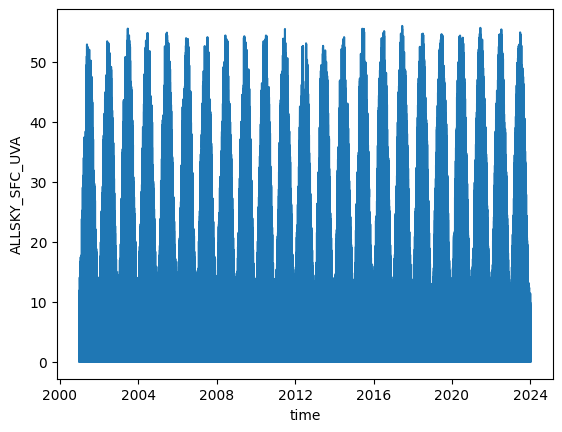

In [9]:
ue(ds).time_series("ALLSKY_SFC_UVA")

# Weather pattern analysis

In [10]:
columns = ['date','ALLSKY_SFC_UVA', 'T2M', 'PRECTOTCORR', 'PS', 'WS10M',
       'WD10M','value']

In [11]:
def plot_timeseries(df, columns):
    colors = cm.rainbow(np.linspace(0, 1, len(columns)))

    fig, axes = plt.subplots(nrows=len(columns),ncols=1, sharex=True, figsize=(8,8))

    for i in range(len(columns)):
        axes[i].plot(pd.to_datetime(df["date"]).dt.date, df[columns[i]].astype(float), label=str(columns[i]),\
                    color=colors[i])
        xmin, xmax = axes[i].get_xlim()
        N=10
        axes[i].set_xticks(np.round(np.linspace(xmin, xmax, N)))


        axes[i].xaxis.set_tick_params(rotation=45)
    fig.legend(bbox_to_anchor=(1.15, .75))
    plt.xlabel("time")


    plt.show()

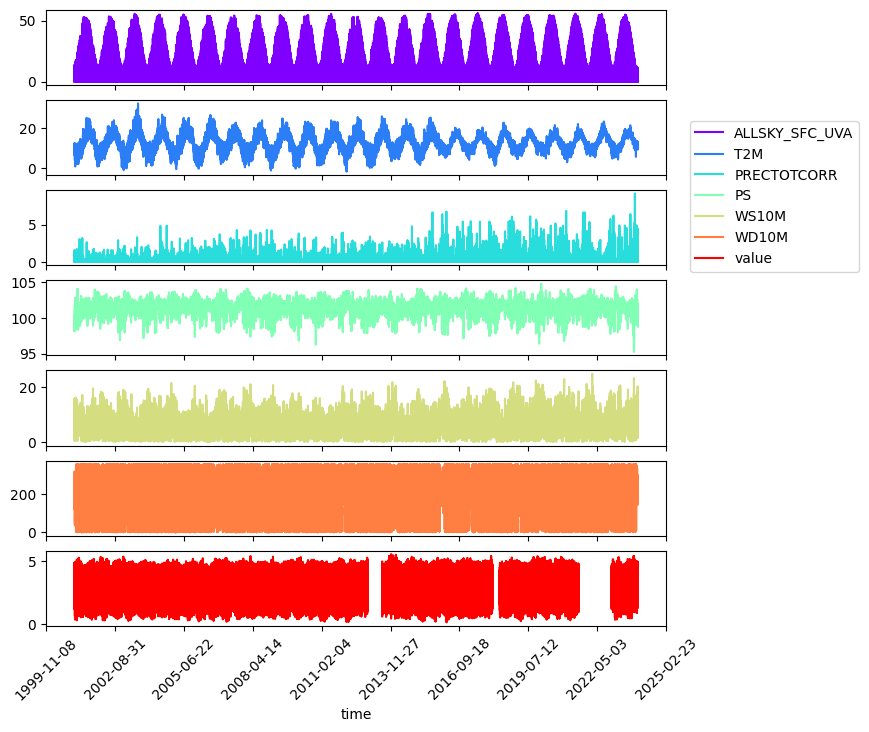

In [12]:
plot_timeseries(ds, columns[1::])

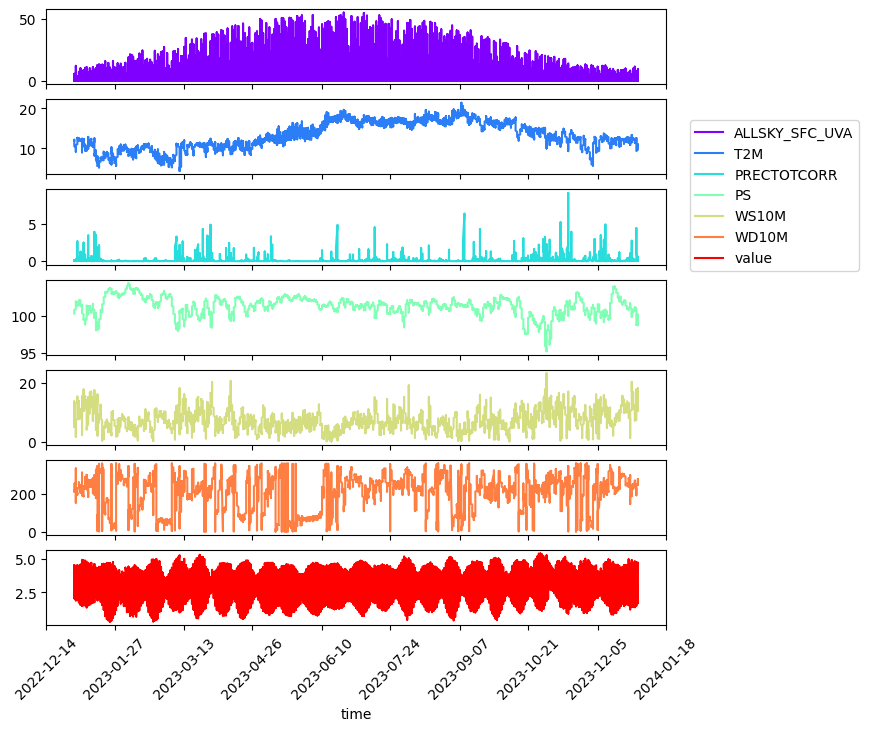

In [13]:
plot_timeseries(ds[pd.to_datetime(ds["date"]).dt.year==2023], columns[1::])

In [14]:
ds_year_max = ds[columns[1::]].groupby(pd.to_datetime(ds["date"]).dt.year).transform('max')
ds_year_min = ds[columns[1::]].groupby(pd.to_datetime(ds["date"]).dt.year).transform('min')

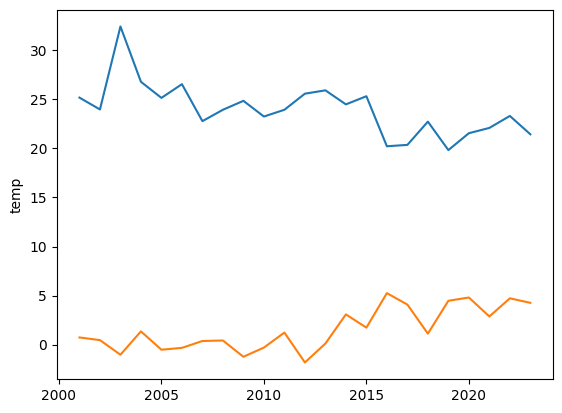

In [15]:
plt.plot(pd.to_datetime(ds["date"]).dt.year, ds_year_max["T2M"])
plt.plot(pd.to_datetime(ds["date"]).dt.year, ds_year_min["T2M"])

plt.ylabel("temp")
plt.show()

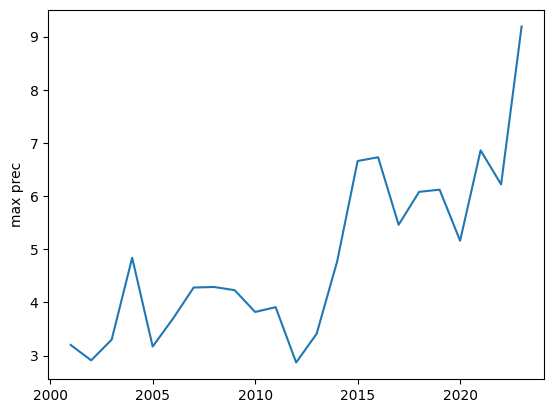

In [16]:
plt.plot(pd.to_datetime(ds["date"]).dt.year, ds_year_max["PRECTOTCORR"])

plt.ylabel("max prec")
plt.show()

In [17]:
def quantiles_check(df, columns):
    q_low = df[columns[0::]].quantile(0.01)
    q_hi  = df[columns[0::]].quantile(0.99)
    
    df_return = df.copy()
    df_return[columns[0::]] = np.where( ((df[columns[0::]] < q_hi) & (df[columns[0::]] > q_low)), df[columns[0::]], np.nan)
    return df_return

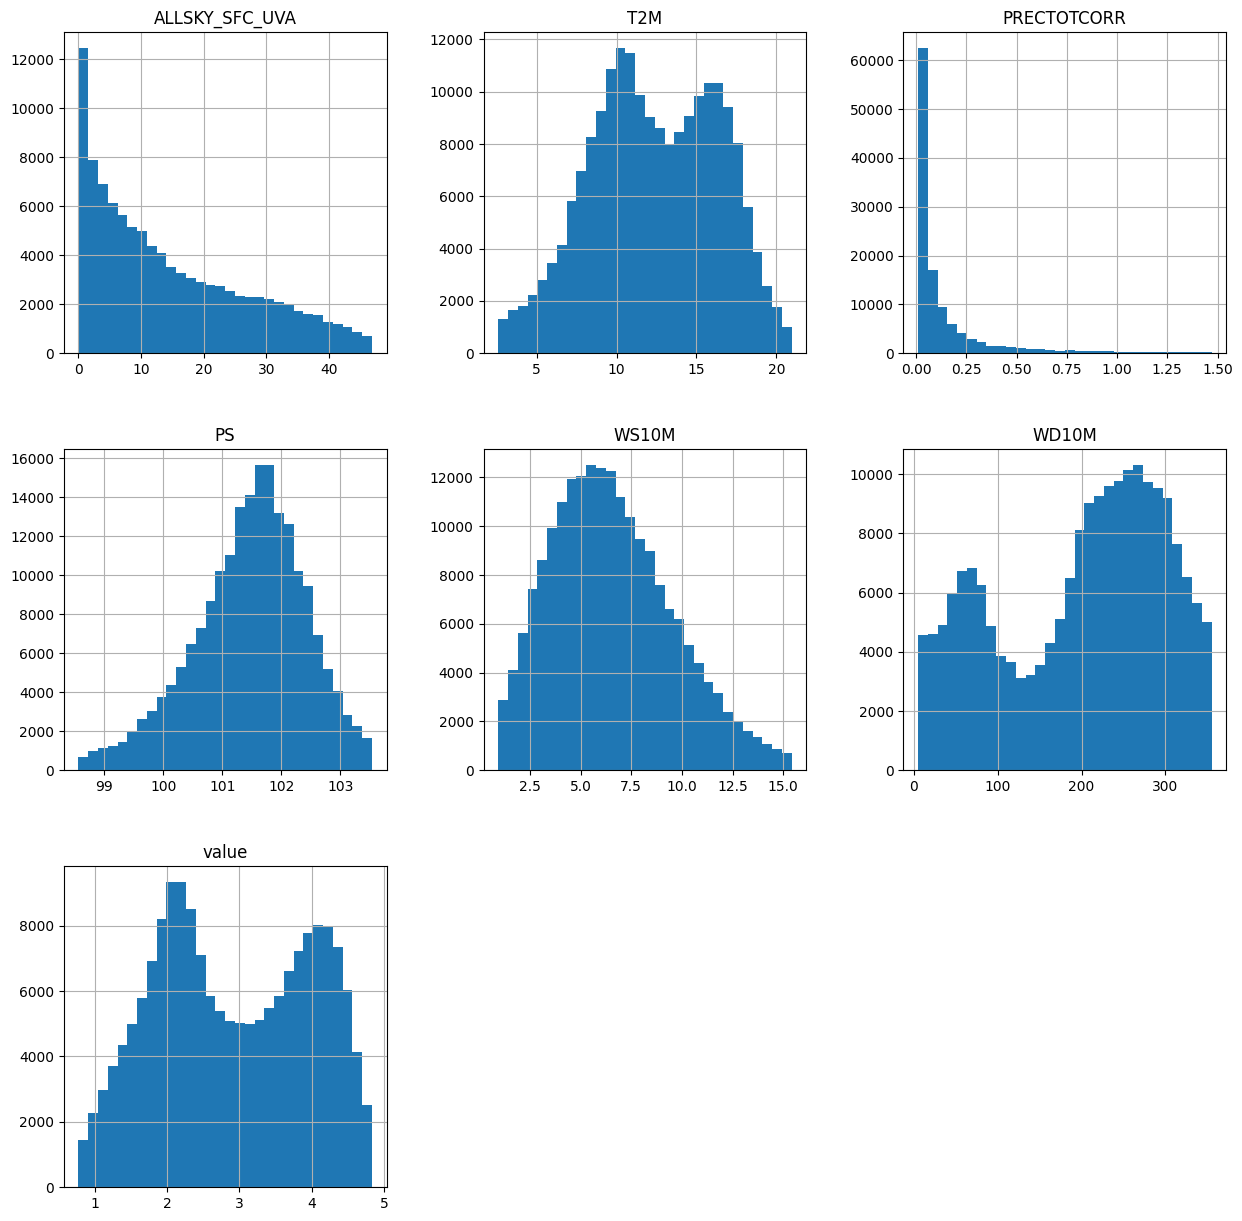

In [18]:
ds_dq = quantiles_check(ds, columns[1::])
ds_dq[columns[1::]].hist(bins=30,  figsize=(15, 15))
plt.show()

## Covariance

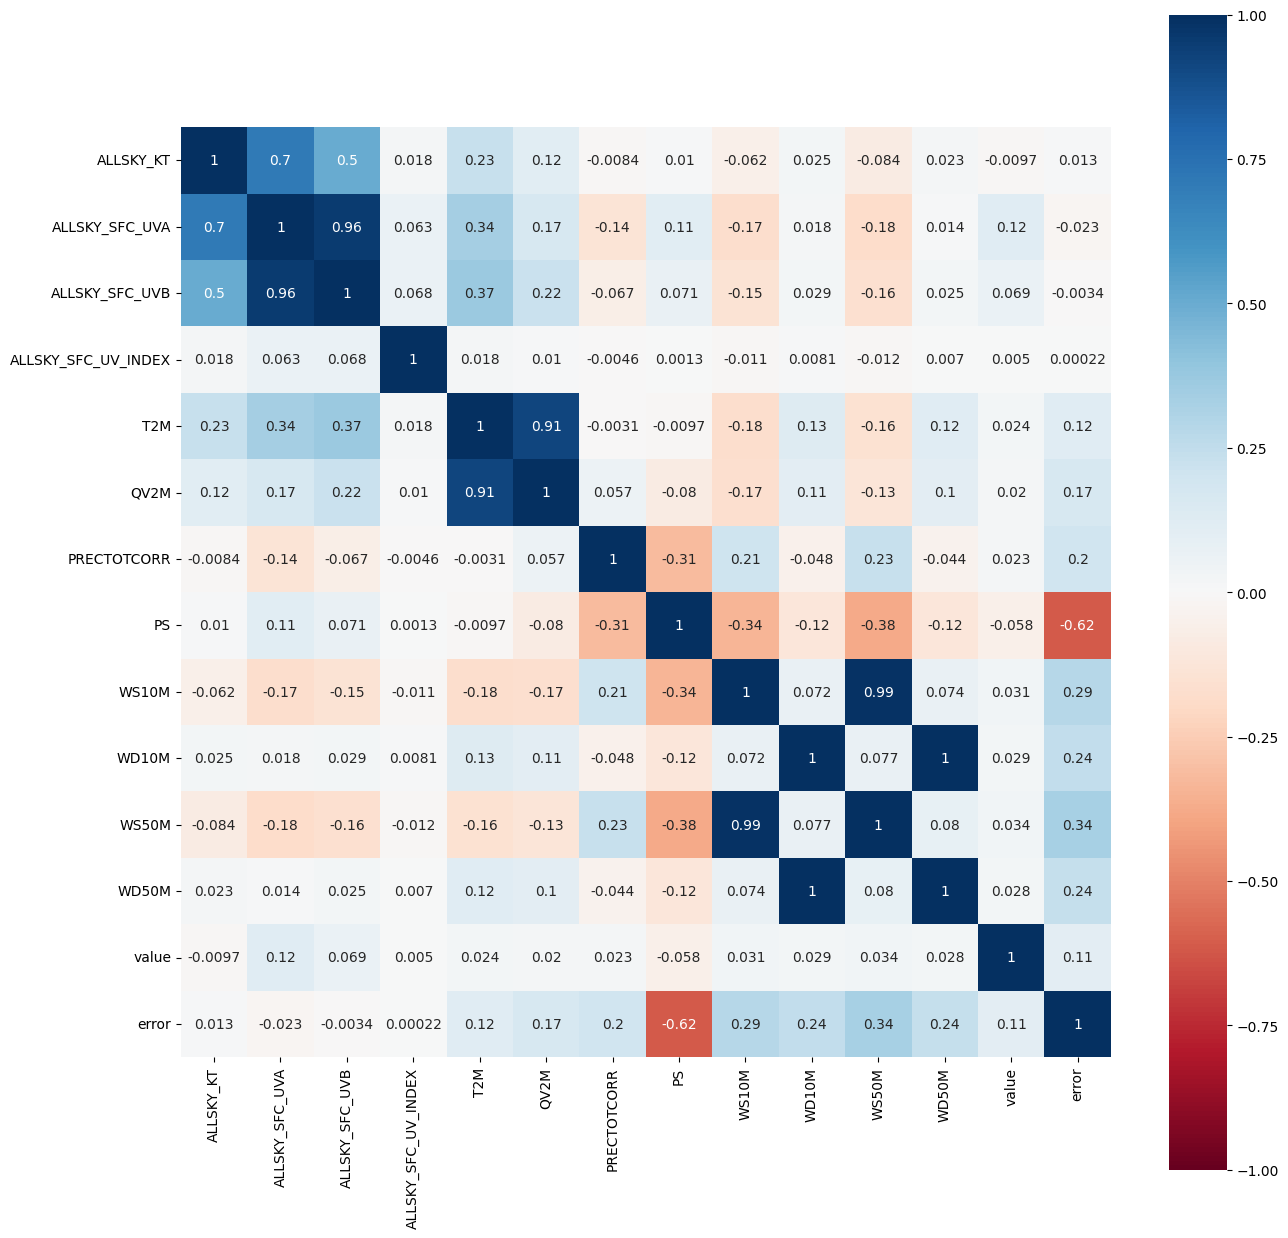

In [19]:
ue(ds_dq).covariance()

We can look into the relation between the tides and the time

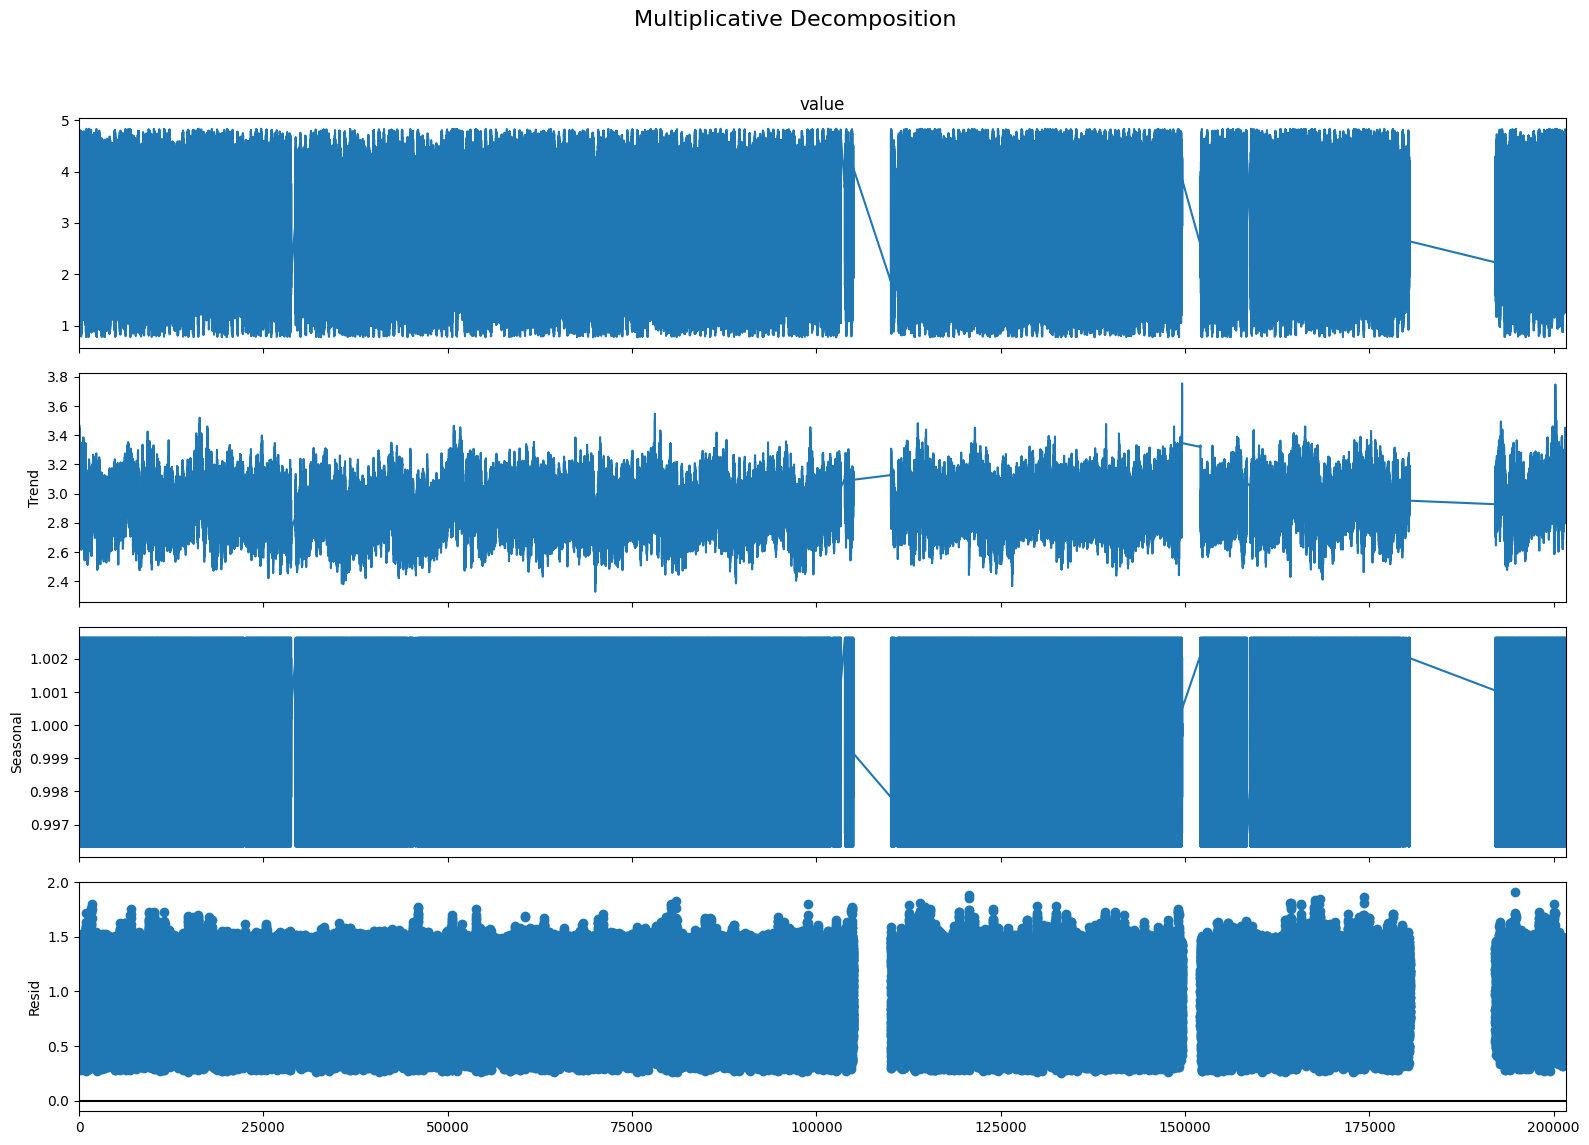

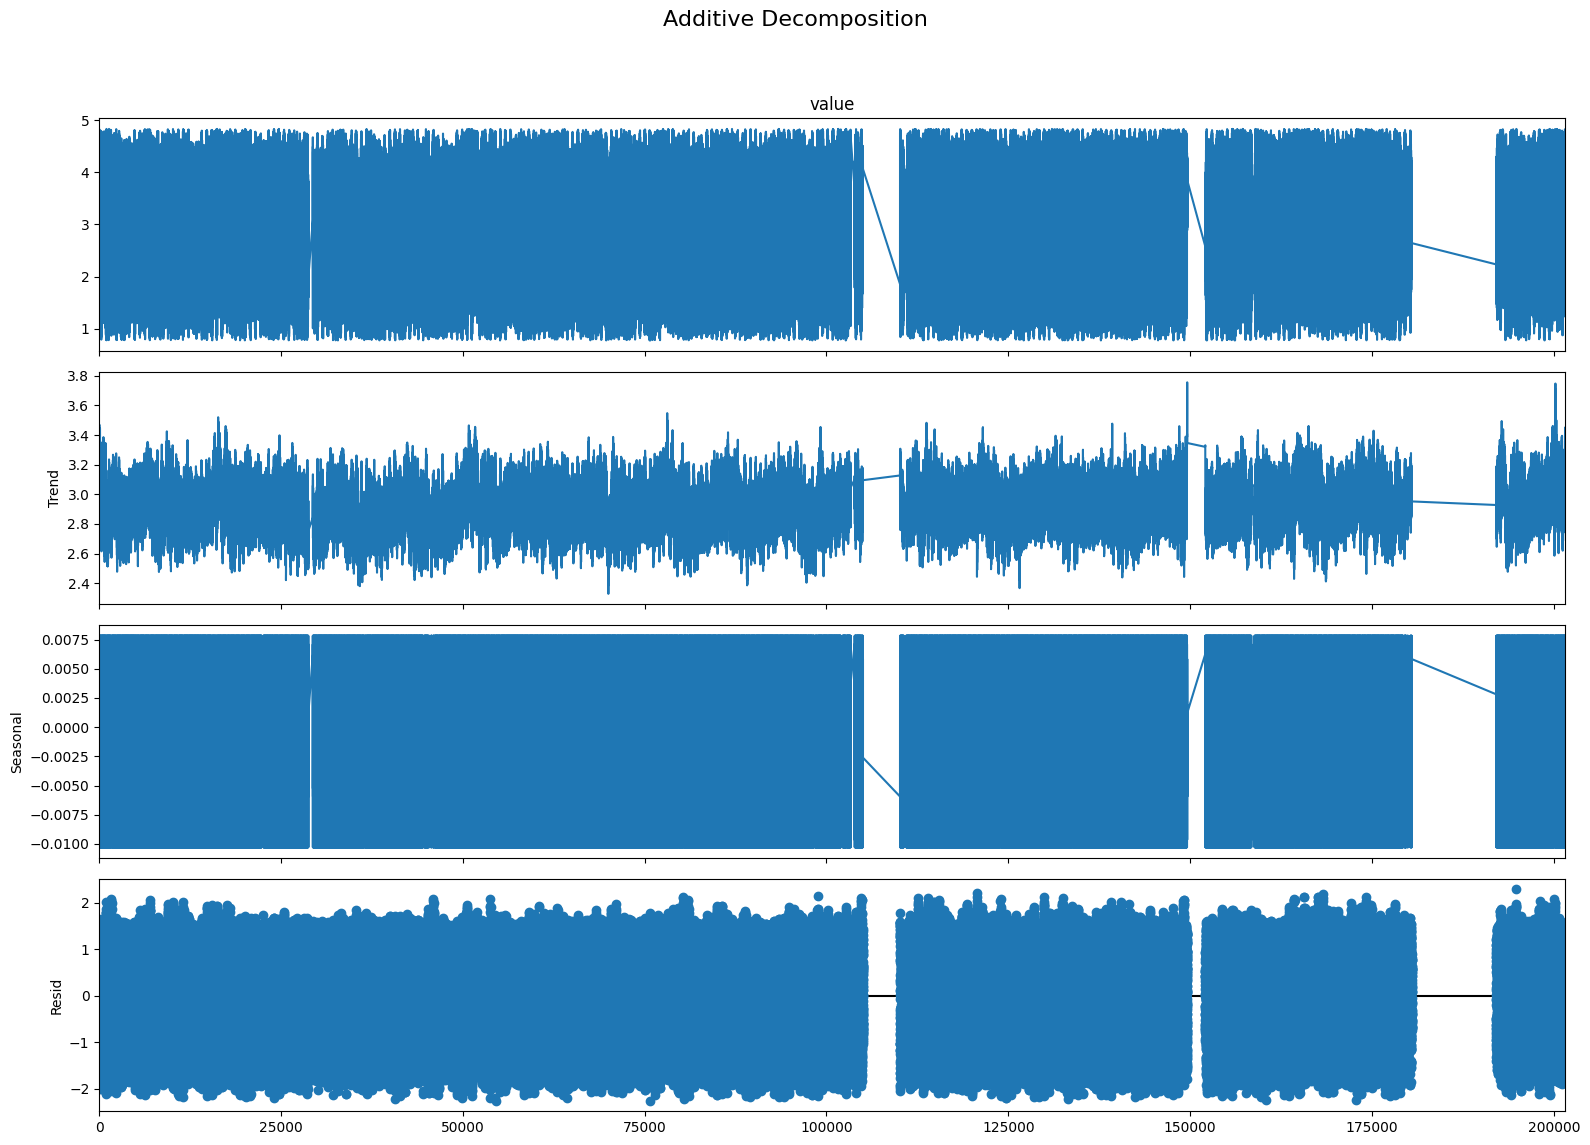

In [20]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse


# Multiplicative Decomposition 
multiplicative_decomposition = seasonal_decompose(ds_dq['value'].dropna(), model='multiplicative', period=30)

# Additive Decomposition
additive_decomposition = seasonal_decompose(ds_dq['value'].dropna(), model='additive', period=30)

# Plot
plt.rcParams.update({'figure.figsize': (16,12)})
multiplicative_decomposition.plot().suptitle('Multiplicative Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

additive_decomposition.plot().suptitle('Additive Decomposition', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

We can see how these decomposition have really high residual --> the dependeny with time is not trivial

We can see if we find any kind of correlation with time features. To do so we do some feature engineering.
We consider:
- time of the day
- season
- trigonometry for month and day
- year

In [21]:
date = pd.to_datetime(ds_dq["date"])


In [22]:
time = date.dt.hour.values
month = date.dt.month
season = np.where(month.isin(np.arange(4,10)), 0, 1)
# Calculating cyclical features for month
sine_month = np.sin(2 * np.pi * date.dt.month.values / 12)
cosine_month = np.cos(2 * np.pi * date.dt.month.values / 12)

# Calculating cyclical features for day (assuming a maximum of 31 days)
sine_day = np.sin(2 * np.pi * date.dt.day.values / 31)
cosine_day = np.cos(2 * np.pi * date.dt.day.values / 31)

year = date.dt.year.values

In [23]:
dataset = pd.DataFrame({'tide': ds_dq["value"], 'time': time, \
                       'season' : season, 'sine_month':sine_month, 'cosine_month':cosine_month,\
                       'sine_day': sine_day, 'cosine_day':cosine_day, 'year':year})

In [24]:
dataset

tide  time  season    sine_month  cosine_month      sine_day  \
0       3.46275     0       1  5.000000e-01      0.866025  2.012985e-01   
1       4.09650     1       1  5.000000e-01      0.866025  2.012985e-01   
2       4.47800     2       1  5.000000e-01      0.866025  2.012985e-01   
3       4.37225     3       1  5.000000e-01      0.866025  2.012985e-01   
4       4.18950     4       1  5.000000e-01      0.866025  2.012985e-01   
...         ...   ...     ...           ...           ...           ...   
201595  1.70950    19       1 -2.449294e-16      1.000000 -2.449294e-16   
201596  1.89425    20       1 -2.449294e-16      1.000000 -2.449294e-16   
201597  2.07825    21       1 -2.449294e-16      1.000000 -2.449294e-16   
201598  2.34200    22       1 -2.449294e-16      1.000000 -2.449294e-16   
201599  2.95475    23       1 -2.449294e-16      1.000000 -2.449294e-16   

        cosine_day  year  
0          0.97953  2001  
1          0.97953  2001  
2          0.97953  2001  
3          0.97953  2001  
4          0.97953  2001  
...            ...   ...  
201595     1.00000  2023  
201596     1.00000  2023  
201597     1.00000  2023  
201598     1.00000  2023  
201599     1.00000  2023  

[201600 rows x 8 columns]

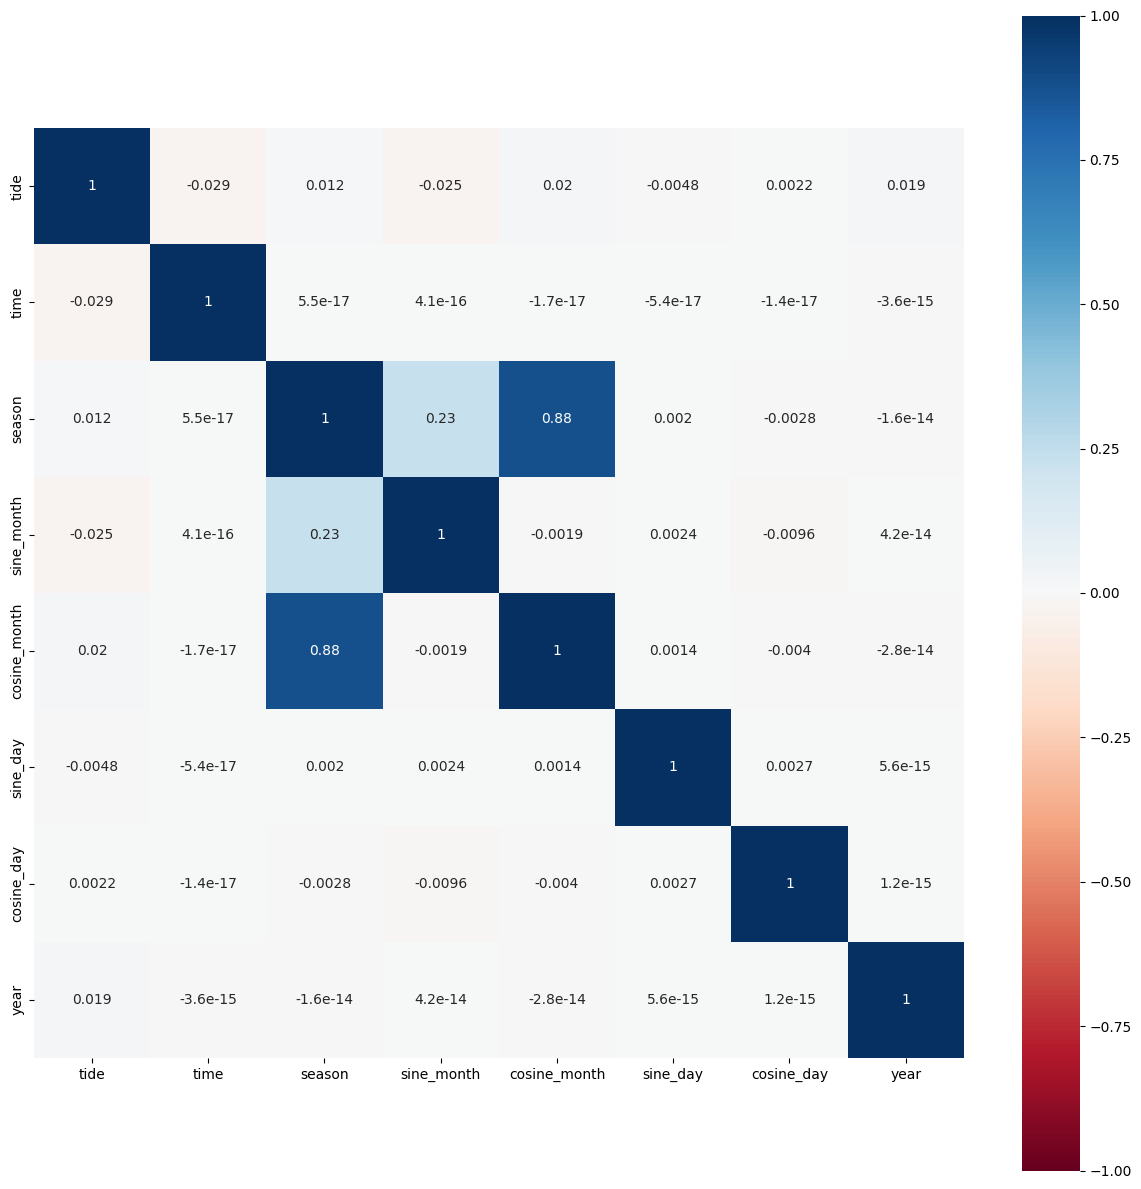

In [25]:
corrmat = dataset.corr().dropna(how="all", axis="columns").dropna(how="all", axis="rows")
f, ax = plt.subplots( figsize=(15, 15))
fig = sns.heatmap(corrmat, vmax=1, square=True, cmap="RdBu",  annot=True, vmin=-1);

plt.show()

# Feature Engineering

In [26]:
ds = quantiles_check(ds, columns[1::])

Let's start with:
- removing repeting info
- renaming columns for ease

In [27]:
ds_core = ds[["date", "ALLSKY_SFC_UVA", "T2M", "QV2M", "PRECTOTCORR", "WS10M", "WD10M", "value", "error"]]

In [28]:
ds_core

date  ALLSKY_SFC_UVA    T2M  QV2M  PRECTOTCORR  WS10M  \
0      2001-01-01 00:00:00             NaN   9.87  7.14         0.51  14.65   
1      2001-01-01 01:00:00             NaN  10.45  7.45         0.23  13.76   
2      2001-01-01 02:00:00             NaN  10.75  7.63         0.47  12.99   
3      2001-01-01 03:00:00             NaN  11.05  7.75         1.04  13.32   
4      2001-01-01 04:00:00             NaN  11.29  7.81         0.41  12.63   
...                    ...             ...    ...   ...          ...    ...   
201595 2023-12-31 19:00:00             NaN  10.93  5.98         0.05    NaN   
201596 2023-12-31 20:00:00             NaN  10.98  5.98         0.04    NaN   
201597 2023-12-31 21:00:00             NaN  10.93  5.98         0.03    NaN   
201598 2023-12-31 22:00:00             NaN  10.92  5.92         0.03  14.98   
201599 2023-12-31 23:00:00             NaN  10.95  5.92         0.02  14.38   

         WD10M    value    error  
0       185.78  3.46275  0.56225  
1       187.93  4.09650  0.51400  
2       188.89  4.47800  0.39975  
3       195.02  4.37225  0.18425  
4       202.79  4.18950  0.11525  
...        ...      ...      ...  
201595  273.14  1.70950  0.45000  
201596  274.27  1.89425  0.36900  
201597  274.82  2.07825  0.12425  
201598  275.12  2.34200  0.06700  
201599  275.74  2.95475  0.22900  

[201600 rows x 9 columns]

In [29]:
ds_core = ds_core.rename(columns={"T2M": "Temp2M", "QV2M": "Humidity2M", 'PRECTOTCORR': "TotPrecip", "value":"TideHeight", "error":"errTideHeight"})


# Imputing

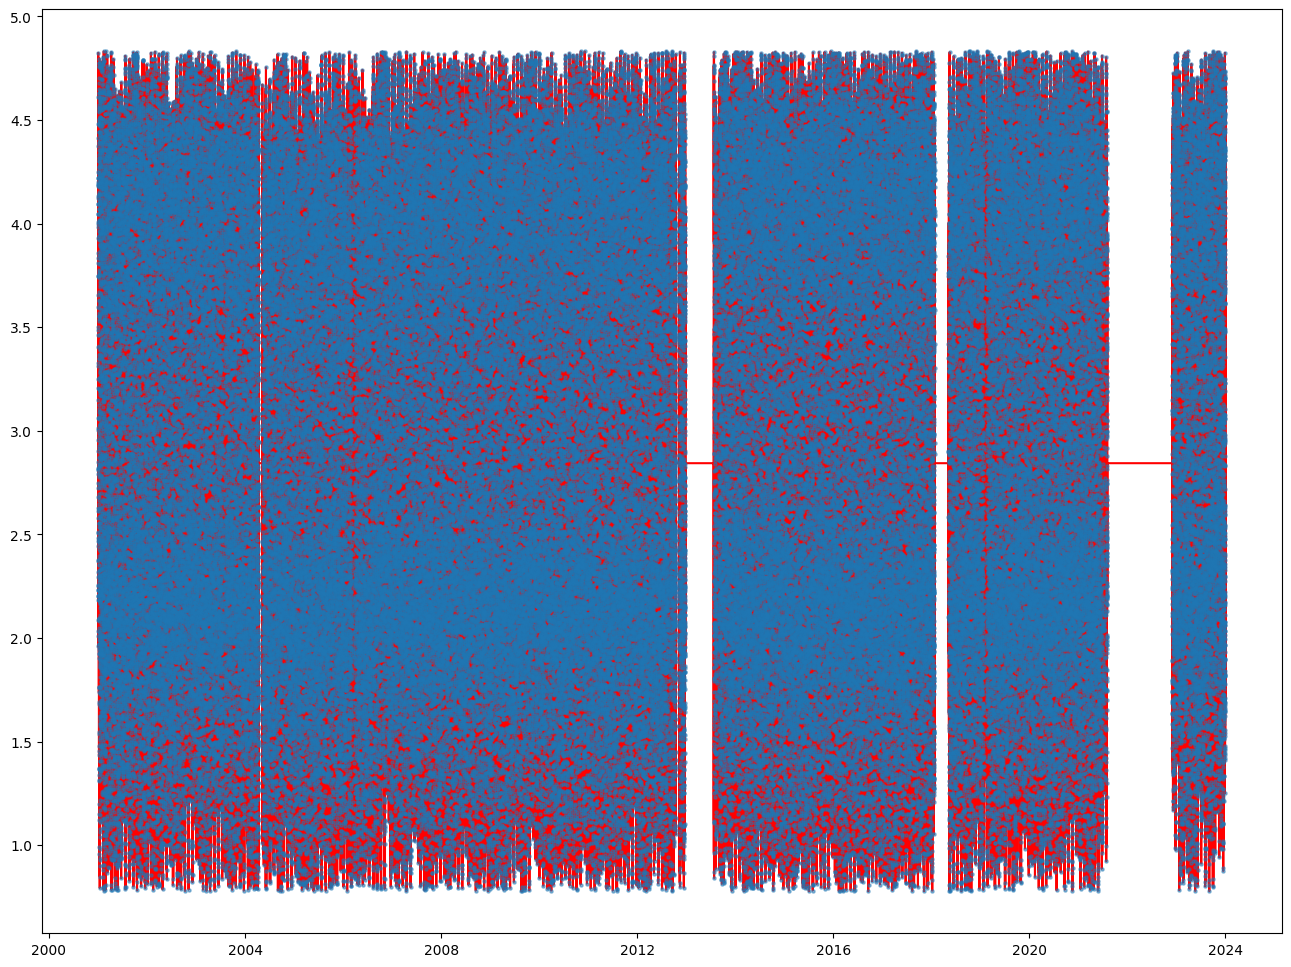

In [30]:
plt.scatter(ds_core["date"], ds_core["TideHeight"], s=5, alpha=0.5)

plt.plot(ds_core["date"], ds_core["TideHeight"].fillna(np.nanmedian(ds_core["TideHeight"])), color="red", zorder=0)

In [31]:
ds_core['date'] = pd.to_datetime(ds_core['date'])
ds_core.set_index('date', inplace=True)

In [32]:
# Create helper features
ds_core['month'] = ds_core.index.month
ds_core['day'] = ds_core.index.day
ds_core['hour'] = ds_core.index.hour

# Group by time of year (seasonal template)
seasonal_template = ds_core.groupby(['month', 'day', 'hour'])["TideHeight"].median()

# Apply imputation
def seasonal_impute(row):
    if pd.isna(row["TideHeight"]):
        return seasonal_template.loc[(row['month'], row['day'], row['hour'])]
    else:
        return row["TideHeight"]

ds_core['value_imputed'] = ds_core.apply(seasonal_impute, axis=1)

In [33]:
ds_core.reset_index(inplace=True)


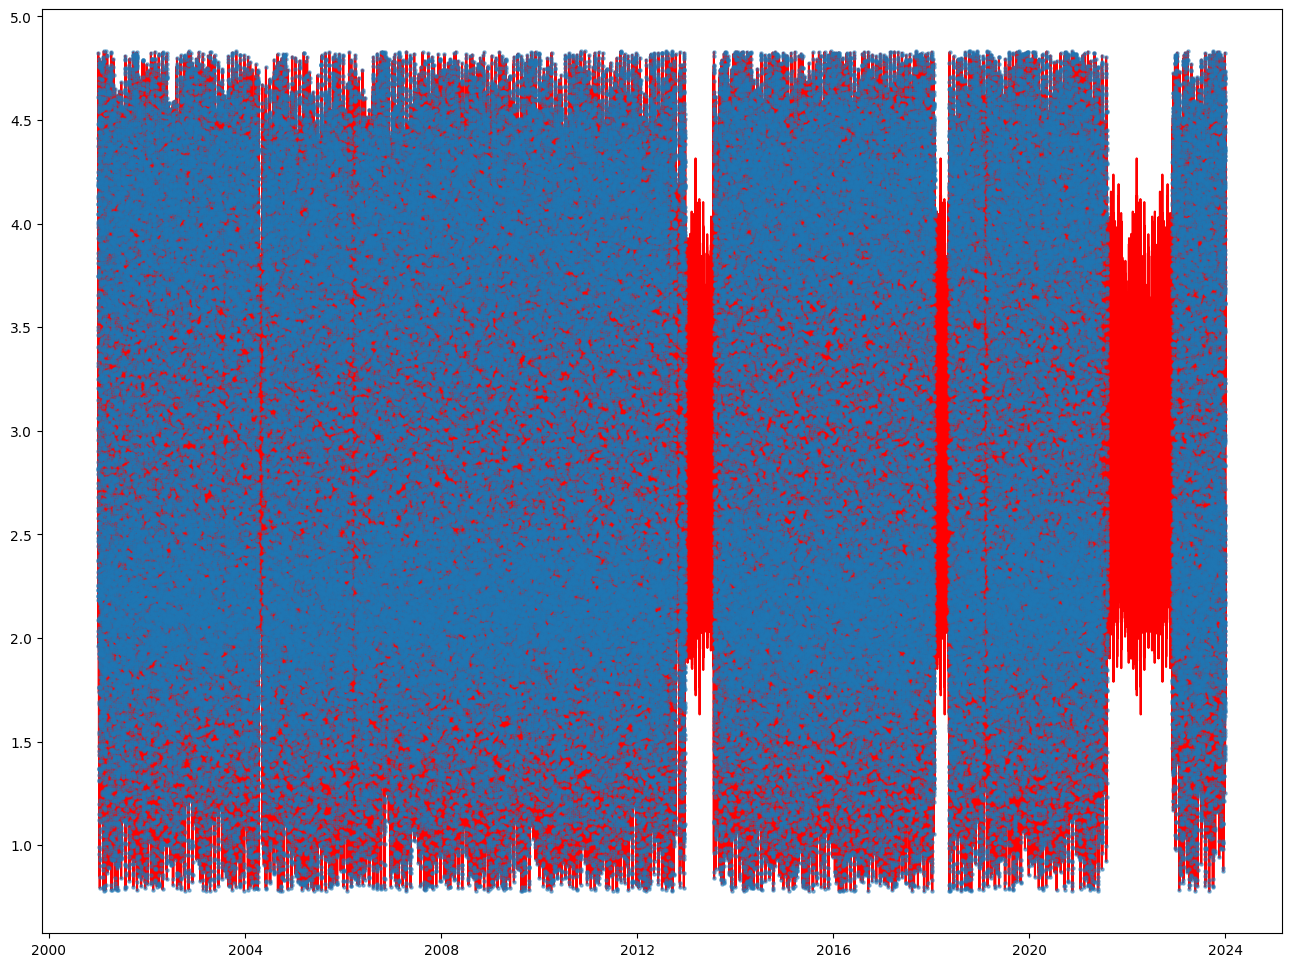

In [34]:
plt.scatter(ds_core["date"], ds_core["TideHeight"], s=5, alpha=0.5)

plt.plot(ds_core["date"], ds_core['value_imputed'], color="red", zorder=0)

In [35]:
ds_core['tide_change'] = ds_core['value_imputed'].diff()

# More aggressive rate of change (like acceleration)
ds_core['tide_rate'] = ds_core['value_imputed'].diff().diff()

# Simple tide phase (categorical): rising, falling, or flat
ds_core['tide_phase'] = np.select(
    [ds_core['tide_change'] > 0.01, ds_core['tide_change'] < -0.01],
    ['rising', 'falling'],
    default='slack'  # slack = near-zero change
)

# 🌬️ Wind Components
# Convert degrees to radians for trig functions
wind_rad = np.deg2rad(ds_core['WD10M'])

# Wind vector decomposition (u = east-west, v = north-south)
ds_core['wind_u'] = ds_core['WS10M'] * np.cos(wind_rad)
ds_core['wind_v'] = ds_core['WS10M'] * np.sin(wind_rad)

# 🌧️ Rain: Time Since Last Dry Hour
is_dry = ds_core['TotPrecip'] < 0.01

# Compute time since last dry hour
ds_core['rain_since_dry'] = (~is_dry).groupby((is_dry != is_dry.shift()).cumsum()).cumsum()

In [39]:
ds_core

date  ALLSKY_SFC_UVA  Temp2M  Humidity2M  TotPrecip  \
0      2001-01-01 00:00:00             NaN    9.87        7.14       0.51   
1      2001-01-01 01:00:00             NaN   10.45        7.45       0.23   
2      2001-01-01 02:00:00             NaN   10.75        7.63       0.47   
3      2001-01-01 03:00:00             NaN   11.05        7.75       1.04   
4      2001-01-01 04:00:00             NaN   11.29        7.81       0.41   
...                    ...             ...     ...         ...        ...   
201595 2023-12-31 19:00:00             NaN   10.93        5.98       0.05   
201596 2023-12-31 20:00:00             NaN   10.98        5.98       0.04   
201597 2023-12-31 21:00:00             NaN   10.93        5.98       0.03   
201598 2023-12-31 22:00:00             NaN   10.92        5.92       0.03   
201599 2023-12-31 23:00:00             NaN   10.95        5.92       0.02   

        WS10M   WD10M  TideHeight  errTideHeight  month  day  hour  \
0       14.65  185.78     3.46275        0.56225      1    1     0   
1       13.76  187.93     4.09650        0.51400      1    1     1   
2       12.99  188.89     4.47800        0.39975      1    1     2   
3       13.32  195.02     4.37225        0.18425      1    1     3   
4       12.63  202.79     4.18950        0.11525      1    1     4   
...       ...     ...         ...            ...    ...  ...   ...   
201595    NaN  273.14     1.70950        0.45000     12   31    19   
201596    NaN  274.27     1.89425        0.36900     12   31    20   
201597    NaN  274.82     2.07825        0.12425     12   31    21   
201598  14.98  275.12     2.34200        0.06700     12   31    22   
201599  14.38  275.74     2.95475        0.22900     12   31    23   

        value_imputed  tide_change  tide_rate tide_phase     wind_u  \
0             3.46275          NaN        NaN      slack -14.575518   
1             4.09650      0.63375        NaN     rising -13.628418   
2             4.47800      0.38150   -0.25225     rising -12.833949   
3             4.37225     -0.10575   -0.48725    falling -12.864928   
4             4.18950     -0.18275   -0.07700    falling -11.643986   
...               ...          ...        ...        ...        ...   
201595        1.70950     -0.35450    0.45725    falling        NaN   
201596        1.89425      0.18475    0.53925     rising        NaN   
201597        2.07825      0.18400   -0.00075     rising        NaN   
201598        2.34200      0.26375    0.07975     rising   1.336845   
201599        2.95475      0.61275    0.34900     rising   1.438207   

           wind_v  rain_since_dry  
0       -1.475387               1  
1       -1.898373               2  
2       -2.007448               3  
3       -3.451961               4  
4       -4.892290               5  
...           ...             ...  
201595        NaN          201596  
201596        NaN          201597  
201597        NaN          201598  
201598 -14.920229          201599  
201599 -14.307899          201600  

[201600 rows x 19 columns]

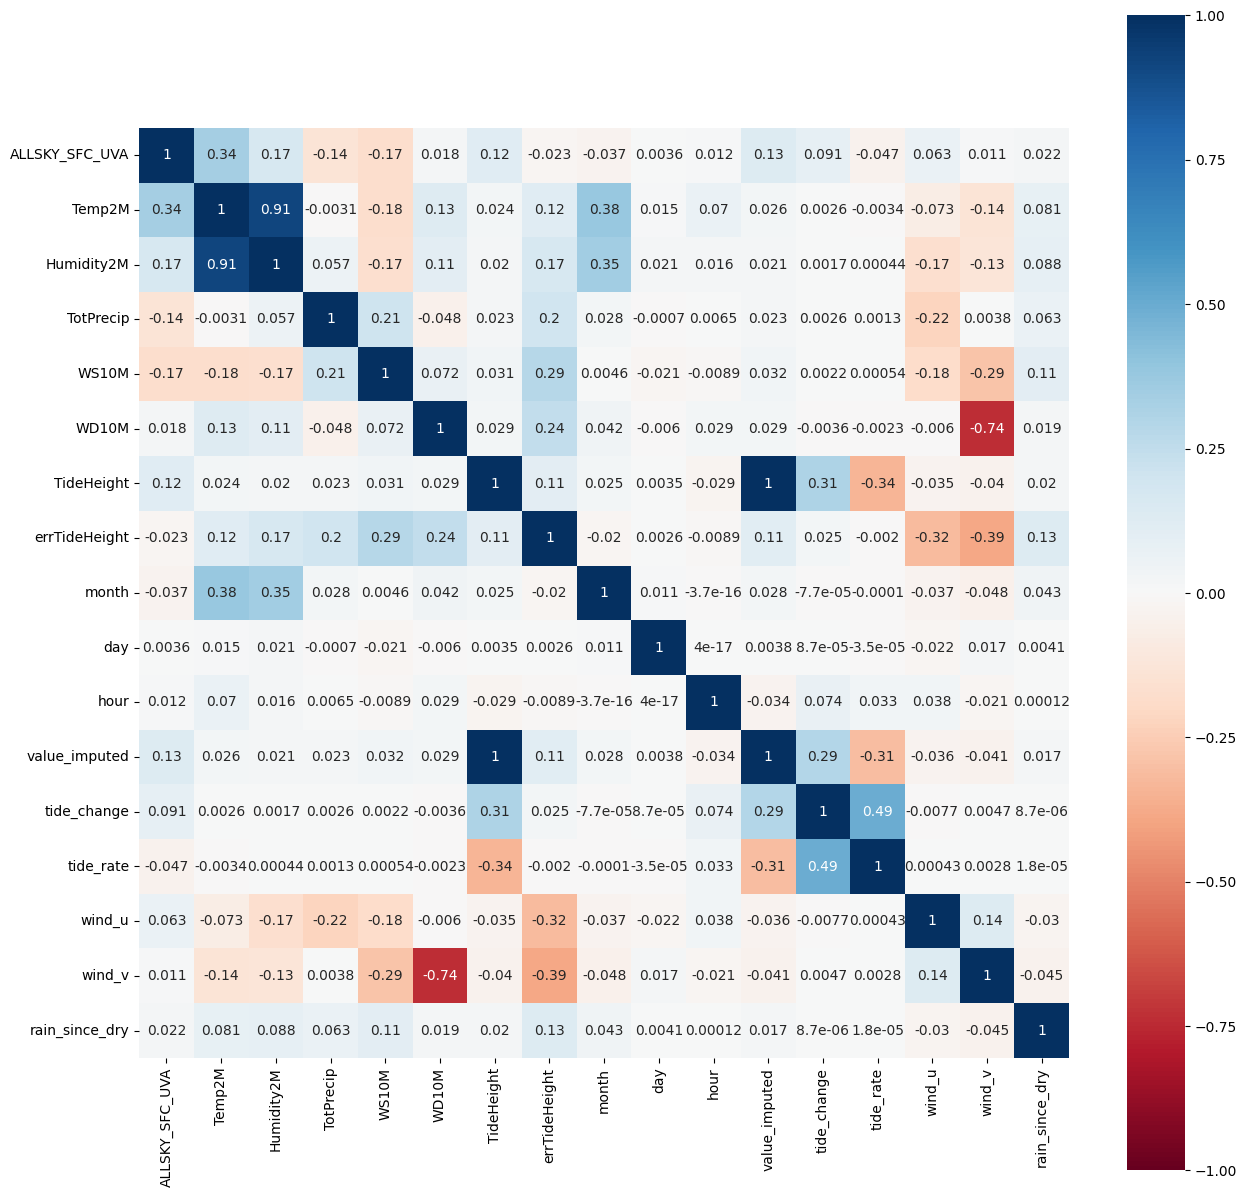

In [40]:
corrmat = ds_core.drop(columns=["date",'tide_phase']).corr().dropna(how="all", axis="columns").dropna(how="all", axis="rows")
f, ax = plt.subplots( figsize=(15, 15))
fig = sns.heatmap(corrmat, vmax=1, square=True, cmap="RdBu",  annot=True, vmin=-1);

plt.show()

In [42]:
ds_core.columns

Index(['date', 'ALLSKY_SFC_UVA', 'Temp2M', 'Humidity2M', 'TotPrecip', 'WS10M',
       'WD10M', 'TideHeight', 'errTideHeight', 'month', 'day', 'hour',
       'value_imputed', 'tide_change', 'tide_rate', 'tide_phase', 'wind_u',
       'wind_v', 'rain_since_dry'],
      dtype='object')

In [43]:
ds_core["TideHeight"] = ds_core["value_imputed"]

In [44]:
ds_core[["date", 'ALLSKY_SFC_UVA',	'Temp2M',	'Humidity2M',	'TotPrecip',	'WS10M',	'WD10M',	'TideHeight',	'errTideHeight', 'tide_change', 'tide_rate', 'tide_phase', 'wind_u',
       'wind_v', 'rain_since_dry']].to_csv(env_data_dr+"postprocessed_WeatherTide_digitaltwin_1h.csv")